# CS342 Coursework

Christos Demetriou 2018918


In [147]:
# Library imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(13)


## Data import initialization


In [116]:
# Data
DATA_PATH = "cw.data"

colors = { # Map classes to colors
    'ES' : 'red',
    'FR' : 'blue',
    'GE' : 'green',
    'IT' : 'yellow',
    'UK' : 'brown',
    'US' : 'purple',
}
idx = { # Map classes to colors
    'ES' : 0,
    'FR' : 1,
    'GE' : 2,
    'IT' : 3,
    'UK' : 4,
    'US' : 5,
}

mp = lambda x : idx[x]

# Dataset has no headers => therefore add false
dataset = pd.read_csv(DATA_PATH,header=None).to_numpy()
np.random.shuffle(dataset)
y,Xnp = dataset[:,0], dataset[:,1:].astype('float')
# Convert categorical data to one_nhot
vhat = np.vectorize(mp)(y)
Xb = np.insert(Xnp,0,1.,axis=1)

## Part I


Visually determine linear sparability


In [117]:
# Misc functions
    
#Code to compute the PCA decomposition
def PCA_decomp(X,m,k=None):
    '''
        X : np.array, Data to decompose
        m : np.array, mean of training data
        k : Optional[int]
        returns V matrix with the top k components
    '''
    X_center = X - m  # Center Data
    # print(X_center.shape)
    _,_,V = np.linalg.svd(X_center,full_matrices = True)
    if k == None:
        return V
    else:
        return V[0:k]

Text(0.5, 1.0, 'With top 2 PCAs')

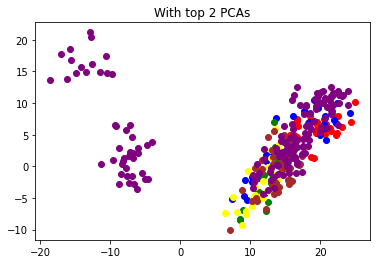

In [118]:
# Data to visualize
m = Xnp.mean(axis=0)
V = PCA_decomp(Xnp,m,None)

Z = Xnp @ V.transpose()


for (acc,col) in colors.items():
    sc_data = Z[y == acc,:]
    plt.scatter(sc_data[:,0],sc_data[:,1],color=col)
plt.title("With top 2 PCAs")

## Part 2 
Determining if data are linearly seperable


### Method 1: Using original feature space


In [119]:
def percept(X,v,lr):
    W = np.zeros((6,X.shape[1])) # Multi-class perceptron
    MAX_ITER = 50
    
    # with learning rate
    for _ in range(MAX_ITER):
        cnt = 0
        for (xi,yi) in zip(X,v):
            x = xi.reshape(X.shape[1],1)
            ar_x = np.argmax(W @ x)
            if ar_x != yi:
                cnt += 1
                W[yi,:] += lr * xi.T
                W[ar_x,:] -= lr * xi.T
        if cnt == 0:
            break
    return W
W = percept(Xb,vhat,1)
uniq,cnts = np.unique(np.argmax(Xb @ W.T,axis=1) == vhat,return_counts=True)
print(f"Accuracy of original feature space {cnts[1] / cnts.sum()}"  )

Accuracy of original feature space 0.6534954407294833


### Method 2 : Use PCA


In [120]:
V = PCA_decomp(Xnp, Xnp.mean(axis=0))
Zs = Xnp @ V.T

In [121]:
Zx = np.insert(Zs,0,1.,axis=1)
for lr in np.arange(0.2,1.2,0.2):
    print(f'---------------- Learning rate {lr} ----------------')
    for i in range(1,13):
        Zb = Zx[:,:i + 1] # including bias
        W = percept(Zb, vhat,lr)
        uniq,cnts = np.unique(np.argmax(Zb @ W.T,axis=1) == vhat,return_counts=True)
        print(f"Dims {i} Accuracy {cnts[1] / cnts.sum()}" , end =', ' )
    print()

---------------- Learning rate 0.2 ----------------
Dims 1 Accuracy 0.3738601823708207, Dims 2 Accuracy 0.48632218844984804, Dims 3 Accuracy 0.48936170212765956, Dims 4 Accuracy 0.44680851063829785, Dims 5 Accuracy 0.364741641337386, Dims 6 Accuracy 0.5167173252279635, Dims 7 Accuracy 0.5592705167173252, Dims 8 Accuracy 0.5653495440729484, Dims 9 Accuracy 0.541033434650456, Dims 10 Accuracy 0.6109422492401215, Dims 11 Accuracy 0.6048632218844985, Dims 12 Accuracy 0.6534954407294833, 
---------------- Learning rate 0.4 ----------------
Dims 1 Accuracy 0.3738601823708207, Dims 2 Accuracy 0.48632218844984804, Dims 3 Accuracy 0.48936170212765956, Dims 4 Accuracy 0.44680851063829785, Dims 5 Accuracy 0.364741641337386, Dims 6 Accuracy 0.5167173252279635, Dims 7 Accuracy 0.5592705167173252, Dims 8 Accuracy 0.5653495440729484, Dims 9 Accuracy 0.541033434650456, Dims 10 Accuracy 0.6109422492401215, Dims 11 Accuracy 0.6048632218844985, Dims 12 Accuracy 0.6534954407294833, 
---------------- Learn

## Method 3 : Use kernel-PCA

In [122]:
# TODO check if data need to be centered

def kernel_construct(v):
    return np.exp(-np.square(
            np.linalg.norm(v[:,:,None] - v.T[None,:,:],axis=1)
        ))

a = np.arange(6).reshape(2,3)

In [151]:
v = (Xnp - Xnp.mean(axis=0)).var(axis=0)

epsilon = 0.05
gs, gb = 1. / (2. * (v.max() + epsilon)) , 1/(2*(v.min() - epsilon))
gammas = np.append(np.arange(gs,gb,0.01),gb)
gammas

array([0.019205  , 0.029205  , 0.039205  , 0.049205  , 0.059205  ,
       0.069205  , 0.079205  , 0.08193924])

In [124]:
K = kernel_construct(Xnp)
def FastGamma(Ks,gammas):
    return np.power(
            np.repeat(Ks[None,:,:], gammas.shape[0], axis=0)
        ,   gammas[:,None,None]
        )
gamma_k = FastGamma(K,gammas)
A = np.ones(gamma_k.shape) / gamma_k.shape[1]
normal_k = gamma_k - A @ gamma_k - gamma_k @ A + (A @ gamma_k) @ A
_,_,V = np.linalg.svd(normal_k,full_matrices=True)
Zs = K @ V
Zs = np.insert(Zs, 0,1.,axis=2) # add bias
# Zs.shape
vhatH = np.repeat(vhat.reshape(vhat.shape[0])[:,None], gammas.shape[0],axis=1)

In [244]:
from itertools import product


def HighDimPercerptron(Zs,vhatH,g_shape):
    BigW = np.zeros((g_shape[0], 6 , Zs.shape[2]))
    MAXITER = 10 
    for (_,(i,vs)) in product(range(MAXITER),enumerate(vhatH)):
        xi = Zs[:,i,:]
        classes = np.argmax(np.einsum("ijk,ik->ij",BigW,xi),axis=1)
        for idx in range(classes.shape[0]):
            if  classes[idx] != vs[idx]:
                BigW[idx,vs[idx],:] += xi[idx,:]
                BigW[idx,classes[idx],:] -= xi[idx,:]
    return BigW

In [245]:
MAX_DIM = Zs.shape[2]
cnt = 0        
grid = np.zeros((317,8))

# k = 150
for k in range(13,MAX_DIM):
    rZ = Zs[:,:,:k]
    BigW = HighDimPercerptron(rZ,vhatH,gammas.shape)
    classes = np.argmax(np.einsum("ijk,ifk->ifj",BigW,rZ),axis=2)
    grid[k-13,:] = np.sum(classes == vhatH.T,axis=1)



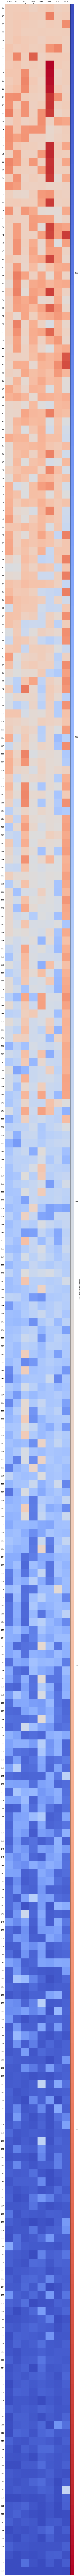

In [174]:
# TODO DOESNT WORK WITH DCS
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots()
fig.set_figheight(300)
fig.set_figwidth(50)
im = ax.imshow(grid,cmap="coolwarm_r")


# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(grid.shape[0]),labels=(np.arange(13,330)))
ax.set_xticks(np.arange(grid.shape[1]),labels=(np.around(gammas,decimals=4)))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)

cbar.ax.set_ylabel("No of correct classifications", rotation=-90, va="bottom")
# Let the horizontal axes labeling appear on top.
ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
plt.show()